<a href="https://colab.research.google.com/github/SongXihao-Alan/Tic-Tac-Toe/blob/main/tic_tac_toe_game_with_random_move.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **调用库**

In [ ]:

!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install imageio>=2.5,<3.0 --upgrade
!pip install imageio imageio-ffmpeg
!pip install pyvirtualdisplay
!pip install tf-agents
!pip install tf-agents[reverb]
!pip install pyglet
import cv2
import gym
from gym import spaces
import base64
import imageio
import unittest
import IPython
import matplotlib
import PIL.Image
import pyvirtualdisplay
import reverb
import numpy as np  # 这是python中常用的指令，调用库numpy并在以后重命名为np
import matplotlib.pyplot as plt # 这是python中常用的指令，调用库matplotlib重的pyplot模块并在以后重命名为plt
import tensorflow as tf # 调用tensorflow库
import imageio

from IPython.display import Video
from tf_agents import utils
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.environments import py_environment
from tf_agents.environments import utils
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.eval.metric_utils import log_metrics
from tf_agents.networks import sequential
from tf_agents.networks import network
from tf_agents.networks import q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import time_step as ts
from tf_agents.specs import tensor_spec
from tf_agents.specs import array_spec
from tf_agents.utils import common
from __future__ import absolute_import, division, print_function
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [637 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,305 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://pp

## **Environment**

In [ ]:
class TicTacToeEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    #define a initial state, empty board
    def __init__(self):
        super(TicTacToeEnv, self).__init__()
        self.board_size = 9 # The length of the board
        self.win_length = 4 # The length of the line needed to win
        self.action_space = spaces.Discrete(self.board_size**2)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(self.board_size, self.board_size), dtype=np.int8)# Define Observation space with 9x9 grid, range of element is -1, 0, 1.

        # Define state_size and action_size
        self.state_size = self.board_size * self.board_size  # Total number of cells in the board
        self.action_size = self.action_space.n  # Total number of possible actions

        self.state = None # Attribute of the enviornment class to None means the enivornment is an unintialized state
        self.current_player = 1 # First player's turn
        self.reset()#start a new game by resetting the environment to a default state

    def current_player(self):
        return self._current_player

    #start a new game by resetting the environment to a initial state, empty board
    def reset(self):
        self.state = np.zeros((self.board_size, self.board_size), dtype=np.int8) # self.state is assigned a new Numpy 9x9 array of zeros.
        self.current_player = 1 # First player's turn for whatever the new game starts
        return self.state  #returns the initial state of the environment, the empty game board


    #Defines how the environment reacts to an action taken by an agent. When agent's action is taken, it suppose to update the enviornment's state.
    def step(self, action):
        row, col = divmod(action, self.board_size)

    # Random move adjustment
        if np.random.rand() < 0.5:
            neighbors = self.get_neighbors(row, col)
            if neighbors:
                row, col = neighbors[np.random.choice(len(neighbors))]
    # If the move is invalid, switch players and return
        if not self.is_valid_move(row, col):
            self.current_player *= -1
            return self.state, 0, False, {"message": "Move forfeited: Jump to the opponent's turn"}

    # Apply the move for the current player
        self.state[row, col] = self.current_player

    # Check for a winner
        winner = self.check_winner()
        done = winner is not None or not np.any(self.state == 0)
        reward = self.calculate_reward(winner)
    # Switch players for the next turn
        self.current_player *= -1

        return self.state, reward, done, {}

    def get_neighbors(self, row, col):
        neighbors = []
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0:
                    continue  # Skip the original cell
                new_row, new_col = row + dr, col + dc
                if self.is_on_board(new_row, new_col):
                    neighbors.append((new_row, new_col))
        return neighbors


    def is_on_board(self, row, col):
        return 0 <= row < self.board_size and 0 <= col < self.board_size #returns True if both the row and column indices are within the range of 0 to self.board_size - 1.

    def is_valid_move(self, row, col): #determines if a move to a given cell is valid.
        return self.is_on_board(row, col) and self.state[row, col] == 0

    # visually rendering the current state of the Tic-Tac-Toe board in the console.
    def render(self, mode='human', close=False):
        if mode == 'rgb_array':
            return self.render_rgb_array()
        else:
            # Correctly indented code block for 'human' mode rendering
            h_line = "+---" * self.board_size + "+"
            print(h_line)
            for row in self.state:
                row_str = "|" + "|".join(' X ' if cell == 1 else ' O ' if cell == -1 else '   ' for cell in row) + "|"
                print(row_str)
                print(h_line)
            if close:
                self.close()

    def render_rgb_array(self):
        # Create an image of the board state
        data = np.zeros((self.board_size, self.board_size, 3), dtype=np.uint8)
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.state[i, j] == 1:
                    data[i, j] = [255, 0, 0]  # Red for player 1
                elif self.state[i, j] == -1:
                    data[i, j] = [0, 0, 255]  # Blue for player 2

        # Convert array to image and resize for better visibility
        img = cv2.resize(data, (300, 300), interpolation=cv2.INTER_NEAREST)
        return img

    def close(self):
        if self.some_resource:  # Check if a certain resource is initialized
            self.some_resource.close()  # Properly close or release the resource
        if self.graphical_interface:  # Check if a graphical interface is used
            self.graphical_interface.destroy()  # Close or destroy the interface

        if self.network_connection:  # Check if there's an open network connection
            self.network_connection.close()  # Close the network connection
        print("Tic-Tac-Toe environment resources have been released.")
        print("Closing Tic-Tac-Toe environment.")

    # Win condition
    def check_winner(self):
    # Check rows, columns, and diagonals for a win
        for row in range(self.board_size):
            for col in range(self.board_size):
                if self.state[row, col] != 0:  # For each cell that is not empty
                # Checking all eight directions
                    if (self.check_line(row, col, 1, 0) or  # Horizontal (right)
                        self.check_line(row, col, 0, 1) or  # Vertical (down)
                        self.check_line(row, col, 1, 1) or  # Diagonal (down-right, ↘)
                        self.check_line(row, col, -1, 1) or  # Diagonal (up-right, ↗)
                        self.check_line(row, col, -1, -1) or  # Diagonal (up-left, ↖)
                        self.check_line(row, col, 1, -1) or  # Diagonal (down-left, ↙)
                        self.check_line(row, col, -1, 0) or  # Vertical (up)
                        self.check_line(row, col, 0, -1)):  # Horizontal (left)
                        return self.state[row, col]
        return None


    def check_line(self, start_row, start_col, d_row, d_col): #start_row and start_col specify the starting cell, and d_row and d_col specify the direction to check in.
        """Check a line of pieces in the board."""
        end_row = start_row + (self.win_length - 1) * d_row
        end_col = start_col + (self.win_length - 1) * d_col
        if 0 <= end_row < self.board_size and 0 <= end_col < self.board_size:
            for i in range(self.win_length): #If any cell in this line does not match the player number in the starting cell, it returns False
                if self.state[start_row + i * d_row, start_col + i * d_col] != self.state[start_row, start_col]:
                    return False
            return True
        return False

    def calculate_reward(self, winner):
        if winner is None:
            return 0  # No winner yet, or it's a draw
        elif winner == 1:
            return 1  # Player 1 wins, reward is 1
        else:
            return -1  # Player 2 wins, reward is -1






In [ ]:
env = TicTacToeEnv()
initial_state = env.reset() #Resetting the Environment
print("Initial State:\n", initial_state)
# Initialize the environment and agent
env.render() #Rendering the Initial State
#action = env.action_space.sample()
action = 77 # Randomly sample an action
state, reward, done, info = env.step(action)
env.render()

print("New State:\n", state)
print("Reward:", reward)
print("Game Over:", done)
print("Additional Info:", info)

Initial State:
 [[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | 

### **test Enviornment**

Check the Win Condition

In [ ]:
# Create an instance of the environment
env = TicTacToeEnv()
print("Current Player before the move:", "Player 1" if env.current_player == 1 else "Player 2")
# Define a board state where player 1 is one move away from winning horizontally
env.state = np.array([
    [ 1,  1,  1,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
])

# Print the current board state before the move
print("Board State Before the Move:")
env.render()

# Winning action for player 1 is to place a marker in the empty spot (row 0, column 3)
winning_action_for_player_1 = 0 * env.board_size + 3  # Convert 2D coordinate to 1D action index

# Perform the action
new_state, reward, done, info = env.step(winning_action_for_player_1)

# Print the board state after the move
print("Board State After the Move:")
env.render()

# Check the result
winner = env.check_winner()
print("Winner:", "Player 1" if winner == 1 else "Player 2" if winner == -1 else "No winner")
print("Reward:", reward)
# Assert the result (this will raise an error if the assertion is false)
assert winner == 1, "Player 1 should have won"
print("Current Player before the move:", "Player 1" if env.current_player == 1 else "Player 2")

Current Player before the move: Player 1
Board State Before the Move:
+---+---+---+---+---+---+---+---+---+
| X | X | X |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
Board State After the Move:
+---+---+---+---+---+---+---+---+---+
| X | X | X | X |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---

In [ ]:
# Create an instance of the environment
env.reset()
env = TicTacToeEnv()
env.current_player = -1
print("Current Player before the move:", "Player 1" if env.current_player == 1 else "Player 2")
# Define a board state where player 1 is one move away from winning horizontally
env.state = np.array([
    [ -1,  -1,  -1,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
])


# Print the board state before the winning move
print("Board State Before the Move (Player 2):")
env.render()

# Print the current board state before the move
print("Board State Before the Move:")
env.render()

# Winning action for player 2 is to place a marker in the empty spot (row 0, column 3)
winning_action_for_player_2 = 0 * env.board_size + 3  # Convert 2D coordinate to 1D action index

print(winning_action_for_player_2)

# Perform the action for player 2
new_state, reward, done, info = env.step(winning_action_for_player_2)

#print(new_state)
# Print the board state after the winning move
print("Board State After the Move (Player 2):")
env.render()

# Check and print the winner
winner = env.check_winner()
print("Winner:", "Player 1" if winner == 1 else "Player 2" if winner == -1 else "No winner")
print("reward", reward)
# Assert the result
assert winner == -1, "Player 2 should have won"

print("Current Player before the move:", "Player 1" if env.current_player == 1 else "Player 2")


Current Player before the move: Player 2
Board State Before the Move (Player 2):
+---+---+---+---+---+---+---+---+---+
| O | O | O |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
Board State Before the Move:
+---+---+---+---+---+---+---+---+---+
| O | O | O |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |
+---+---+---+---

 Check the Reward Condition

Check the Moving Condition

In [ ]:
# Create an instance of the environment
env = TicTacToeEnv()

# Normal Move
action = env.board_size * 5 + 5  # Convert 2D coordinate (5,5) to action
env.step(action)
# Check the updated state, neighbors, etc.

# Move when cell is taken
env.reset()
env.state[5, 4] = 1  # Mark cell (5,4) as taken
env.step(action)

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8),
 0,
 False,
 {})

## **Hyperparameters**

In [ ]:
# Set up hyperparameters
replay_buffer_max_length = 100  # @param {type:"integer"}这指定了重播缓冲区的最大长度。重播缓冲区用于存储过去的经验，以便代理可以从中学习。
batch_size = 32  # @param {type:"integer"} 这指定了从重播缓冲区中提取的每个批次的大小，以进行训练。
learning_rate = 1e-3  # @param {type:"number"}这是优化器的学习率，它影响了模型权重的更新速度。
log_interval = 10  # @param {type:"integer"}这指定了日志记录间隔，用于监控训练过程。

# Define the total number of training episodes
total_episodes = 2  # Train for 100 episodes
num_eval_episodes = 10  # @param {type:"integer"}这指定了每个评估周期中要运行的评估周期数。
evaluation_interval = 10  # @param {type:"integer"}这指定了评估间隔，即在每次训练迭代之间进行模型评估的频率。
update_target_network = 10  # Update target network every 100 episodes
capture_video_every = 10  # Interval for capturing videos


## **Network（Q**-Network）

In [ ]:
class DQN(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(24, activation='relu', input_shape=(state_size,))
        self.dropout1 = tf.keras.layers.Dropout(0.2)
        self.dense2 = tf.keras.layers.Dense(24, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(0.2)
        self.dense3 = tf.keras.layers.Dense(action_size, activation='linear')

    def call(self, state):
        x = self.dense1(state)
        x = self.dropout1(x, training=True)
        x = self.dense2(x)
        x = self.dropout2(x, training=True)
        return self.dense3(x)

## **Agent**

agent for e-greedy policy

In [ ]:
import random
# DQN代理
class DDQNAgent:
    def __init__(self, state_size, action_size, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(100000)
        self.gamma = 0.95  # 折扣因子
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.update_target_model()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.policy = EpsilonGreedyPolicy(epsilon, epsilon_min, epsilon_decay, action_size)

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        q_values = self.model.predict(state)
        return self.policy.select_action(q_values)

    def remember(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

    def replay(self, batch_size):
        #Check if Memory is Sufficient:
        if len(self.memory.buffer) < batch_size:
            return

        #Sampling from Replay Buffer:
        minibatch = self.memory.sample(batch_size)

        #Processing Each Sample:
        for state, action, reward, next_state, done in minibatch:
            target = self.model(state).numpy()
            if done:
                target[0][action] = reward
            else:
                t = self.target_model(next_state)[0]
                target[0][action] = reward + self.gamma * np.amax(t)

            #Training the Model:
            with tf.GradientTape() as tape:
                tape.watch(self.model.trainable_variables)
                q_values = self.model(state)
                loss = tf.keras.losses.MSE(target, q_values)
            grads = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        #Epsilon Update:
        self.policy.update_epsilon()

        #if self.epsilon > self.epsilon_min:
        #    self.epsilon *= self.epsilon_decay

agent for SARSA policy

In [ ]:
class SARSAAgent:
    def __init__(self, state_size, action_size, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(100000)
        self.gamma = 0.95  # Discount factor
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.update_target_model()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.policy = SARSAPolicy(epsilon, epsilon_min, epsilon_decay, action_size)

    def compile_models(self, learning_rate=0.001):
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=self.optimizer, loss=tf.keras.losses.MeanSquaredError())
        self.target_model.compile(optimizer=self.optimizer, loss=tf.keras.losses.MeanSquaredError())


    def update_target_model(self):
        # Update weights
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        # Action selection using SARSA policy
        return self.policy.select_action(state, self.model)

    def remember(self, state, action, reward, next_state, done):
        # Store experience in memory
        self.memory.add(state, action, reward, next_state, done)

    def replay(self, batch_size):
        if len(self.memory.buffer) < batch_size:
            return

        minibatch = self.memory.sample(batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)[0]
            if done:
                target[action] = reward
            else:
                # SARSA: Use current policy to select the next action
                next_action = self.policy.select_action(next_state, self.model)
                target_q = self.target_model.predict(next_state)[0][next_action]
                target[action] = reward + self.gamma * target_q

            target_f = self.model.predict(state)
            target_f[0][action] = target[action]
            self.model.fit(state, target_f, epochs=1, verbose=0)

        self.policy.update_epsilon()


## **策略**

**e-greedy policy**

In [ ]:
import numpy as np
import random

class EpsilonGreedyPolicy:
    def __init__(self, epsilon, epsilon_min, epsilon_decay, action_size):
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.action_size = action_size

    def select_action(self, q_values):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(q_values)

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


**SARSA policy**

In [ ]:
class SARSAPolicy:
    def __init__(self, epsilon, epsilon_min, epsilon_decay, action_size):
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.action_size = action_size

    def select_action(self, state, model):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        else:
            q_values = model.predict(state)
            return np.argmax(q_values[0])

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


## **reply buffer**

为了跟踪从环境中收集的数据，我们将使用 Reverb，这是 Deepmind 的一个高效、可扩展且易于使用的reply system。 当我们收集trajectories时，它会存储经验数据并在训练期间消耗。此replay buffer是使用描述要存储的tensors的规范构建的，可以使用 agent.collect_data_spec 从代理获取tensor

In [ ]:
'''
创建 Replay Buffer:
'''
from collections import deque

# Your existing code for ReplayBuffer and other classes
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def __len__(self):
        return len(self.buffer)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)


## **评估**

In [ ]:
def compute_avg_return(environment, agent, num_episodes=10):
    # Store the original epsilon value
    original_epsilon = agent.policy.epsilon

    # Set epsilon to 0 to disable exploration
    agent.policy.epsilon = 0

    total_return = 0.0
    for _ in range(num_episodes):
        state = environment.reset()
        state = np.reshape(state, [1, environment.state_size])
        episode_return = 0.0
        while True:
            action = agent.act(state)
            state, reward, done, _ = environment.step(action)
            state = np.reshape(state, [1, environment.state_size])
            episode_return += reward
            if done:
                break
        total_return += episode_return

    # Restore the original epsilon value
    agent.policy.epsilon = original_epsilon
    return total_return


## **训练**

In [ ]:
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# Assuming DDQNAgent and TicTacToeEnv are defined and initialized

In [ ]:
def create_video(frames, filename='training_video.mp4', fps=10):
    if not frames:
        print("No frames to create video.")
        return
    height, width, _ = frames[0].shape
    video = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    for frame in frames:
        video.write(frame)
    video.release()

In [ ]:
env = TicTacToeEnv()
agent = DDQNAgent(state_size=env.state_size, action_size=env.action_size)
frames = []
all_frames = []  # To store frames for the complete video
# Variables to track the number of wins and draws
player_1_wins = 0
player_2_wins = 0
draws = 0

for episode in range(total_episodes):
    state = env.reset()
    state = np.reshape(state, [1, env.state_size])
    avg_reward = 0
    episode_frames = []  # To store frames for the current episode

    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        frame = env.render(mode='rgb_array')
        if frame is not None:
            episode_frames.append(frame)
            all_frames.append(frame)  # Also add to the complete video frames list

        next_state = np.reshape(next_state, [1, env.state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if done:
            winner = env.check_winner()
            if winner == 1:
                player_1_wins += 1
            elif winner == -1:
                player_2_wins += 1
            else:
                draws += 1
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        if done:
            break
    print(f"Captured {len(episode_frames)} frames in Episode {episode + 1}")

    # Evaluate average reward every 'evaluation_interval' episodes
    if (episode + 1) % evaluation_interval == 0:
        avg_reward = compute_avg_return(env, agent, num_eval_episodes)
        print(f"Episode: {episode + 1}, Average Reward: {avg_reward}")

    # Create video for the current episode
    if episode_frames and (episode + 1) % capture_video_every == 0:
        create_video(episode_frames, filename=f'training_video_episode_{episode+1}.mp4')
        print(f"Video created for Episode {episode + 1}")


# Create a complete video after all episodes
if all_frames:
    create_video(all_frames, filename='complete_training_video.mp4')
    print("Complete training video created")
else:
    print("No frames to create the complete video.")

# After all episodes
print(f"Player 1 Wins: {player_1_wins}, Player 2 Wins: {player_2_wins}, Draws: {draws}")

1/1 [==============================] - 0s 35ms/step
Captured 167 frames in Episode 1
1/1 [==============================] - 0s 21ms/step
Captured 27 frames in Episode 2
Complete training video created
Player 1 Wins: 2, Player 2 Wins: 0, Draws: 0


In [ ]:
env = TicTacToeEnv()
agent = DDQNAgent(state_size=env.state_size, action_size=env.action_size)
frames = []
all_frames = []  # To store frames for the complete video

# Variables to track the number of wins and draws
player_1_wins = 0
player_2_wins = 0
draws = 0
total_reward_all_episodes = 0  # Total reward across all episodes

for episode in range(total_episodes):
    state = env.reset()
    state = np.reshape(state, [1, env.state_size])
    episode_reward = 0  # Reward for the current episode
    episode_frames = []  # To store frames for the current episode

    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        frame = env.render(mode='rgb_array')
        if frame is not None:
            episode_frames.append(frame)
            all_frames.append(frame)  # Also add to the complete video frames list

        next_state = np.reshape(next_state, [1, env.state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward  # Accumulate reward for the current episode

        if done:
            winner = env.check_winner()
            if winner == 1:
                player_1_wins += 1
            elif winner == -1:
                player_2_wins += 1
            else:
                draws += 1
            break

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

    # Update total reward across all episodes
    total_reward_all_episodes += episode_reward

    # Print summary of the episode
    print(f"Episode {episode + 1} finished. Player 1 Wins: {player_1_wins}, Player 2 Wins: {player_2_wins}, Draws: {draws}, Episode Reward: {episode_reward}")

    # Create video for the current episode
    if episode_frames and (episode + 1) % capture_video_every == 0:
        create_video(episode_frames, filename=f'training_video_episode_{episode+1}.mp4')
        print(f"Video created for Episode {episode + 1}")

# Create a complete video after all episodes
if all_frames:
    create_video(all_frames, filename='complete_training_video.mp4')
    print("Complete training video created")
else:
    print("No frames to create the complete video.")

# Print final summary
print(f"Total Episodes: {total_episodes}, Player 1 Wins: {player_1_wins}, Player 2 Wins: {player_2_wins}, Draws: {draws}, Total Reward: {total_reward_all_episodes}")


1/1 [==============================] - 0s 23ms/step
Episode 1 finished. Player 1 Wins: 1, Player 2 Wins: 0, Draws: 0, Episode Reward: 1
1/1 [==============================] - 0s 23ms/step
Episode 2 finished. Player 1 Wins: 1, Player 2 Wins: 1, Draws: 0, Episode Reward: -1
Complete training video created
Total Episodes: 2, Player 1 Wins: 1, Player 2 Wins: 1, Draws: 0, Total Reward: 0


training SARSA agent using SARSA policy

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [ ]:

env = TicTacToeEnv()
agent = SARSAAgent(state_size=env.state_size, action_size=env.action_size)
frames = []
all_frames = []  # To store frames for the complete video
agent.compile_models(learning_rate=0.001)

# Variables to track the number of wins and draws
player_1_wins = 0
player_2_wins = 0
draws = 0
total_reward_all_episodes = 0  # Total reward across all episodes
train_every_n_steps = 10  # Define how often you want to train
step_counter = 0  # Keep track of steps


for episode in range(total_episodes):
    state = env.reset()
    state = np.reshape(state, [1, env.state_size])
    episode_reward = 0  # Reward for the current episode
    episode_frames = []  # To store frames for the current episode

    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        frame = env.render(mode='rgb_array')
        if frame is not None:
            episode_frames.append(frame)
            all_frames.append(frame)

        next_state = np.reshape(next_state, [1, env.state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward  # Accumulate reward for the current episode

        if len(agent.memory) > batch_size and step_counter % train_every_n_steps == 0:
            agent.replay(batch_size)
        step_counter += 1

        if done:
            winner = env.check_winner()
            if winner == 1:
                player_1_wins += 1
            elif winner == -1:
                player_2_wins += 1
            else:
                draws += 1
            break

    print(f"Captured {len(episode_frames)} frames in Episode {episode + 1}")
    #total_rewards.append(total_reward)
    # Episode summary
    print(f"Episode {episode + 1} finished. Player 1 Wins: {player_1_wins}, Player 2 Wins: {player_2_wins}, Draws: {draws}, Episode Reward: {episode_reward}")

    # Create video for the current episode
    if episode_frames and (episode + 1) % capture_video_every == 0:
        create_video(episode_frames, filename=f'training_video_episode_{episode+1}.mp4')
        print(f"Video created for Episode {episode + 1}")

# Create a complete video after all episodes
if all_frames:
    create_video(all_frames, filename='complete_training_video_SARSA_agent.mp4')
    print("Complete training video created")
else:
    print("No frames to create the complete video.")

# Print final summary
print(f"Total Episodes: {total_episodes}, Player 1 Wins: {player_1_wins}, Player 2 Wins: {player_2_wins}, Draws: {draws}, Total Reward: {total_reward_all_episodes}")


Captured 39 frames in Episode 1
Episode 1 finished. Player 1 Wins: 1, Player 2 Wins: 0, Draws: 0, Episode Reward: 1
1/1 [==============================] - 0s 34ms/step
Captured 36 frames in Episode 2
Episode 2 finished. Player 1 Wins: 1, Player 2 Wins: 1, Draws: 0, Episode Reward: -1
Complete training video created
Total Episodes: 2, Player 1 Wins: 1, Player 2 Wins: 1, Draws: 0, Total Reward: 0


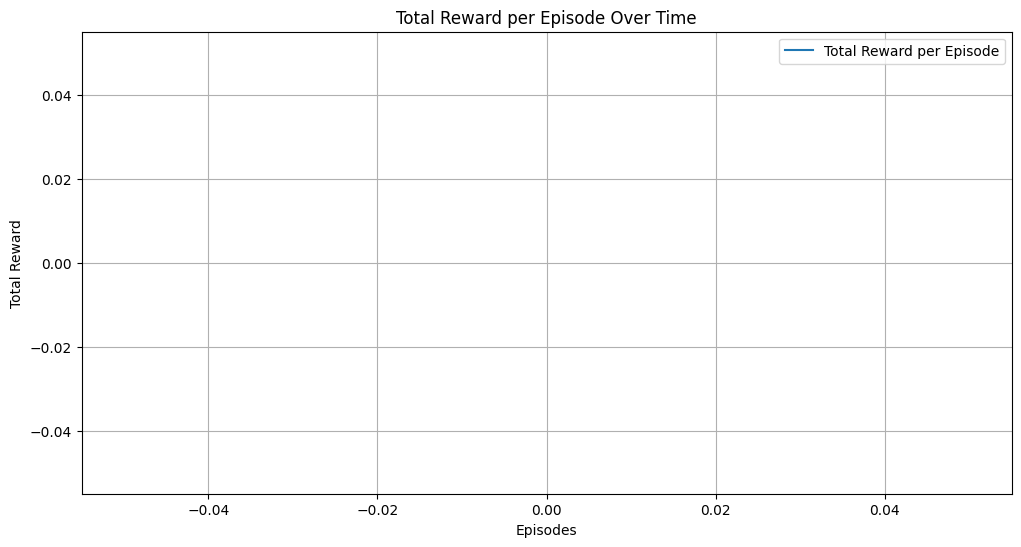

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(total_reward_all_episodes, label='Total Reward per Episode')  # Plot the total rewards
plt.xlabel('Episodes')  # Label for x-axis
plt.ylabel('Total Reward')  # Label for y-axis
plt.title('Total Reward per Episode Over Time')  # Title of the plot
plt.legend()  # Add a legend
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot


## **可视化**

In [ ]:
# Training Loop with Video Capturing
from google.colab import files
files.download('complete_training_video_SARSA_agent.mp4')  # Adjust filename as needed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Training Loop with Video Capturing
from google.colab import files
files.download('complete_training_video.mp4')  # Adjust filename as needed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>